In [1]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.constants import e as ECHARGE
from scipy.constants import h as PLANK_CONST
from scipy.optimize import curve_fit
from uncertainties import ufloat
from scipy.odr import *
from numpy.lib.scimath import sqrt as csqrt
import uncertainties.umath as unp
import pandas as pd
import tarfile as tf
import json as js

GAMMA = 4.596163e7/(2*np.pi) # Hz/T
QUADMOM = 0.314e-28 # m^2

def lorentz(x, amp, fwhm, x0):
    val = amp*(fwhm/2)**2/((x - x0)**2 + (fwhm/2)**2)
    return val

def lorentz_sum(params, x):
    s = np.zeros(x.size)
    for i in range(int(len(params)/3)):
        s += lorentz(x, *params[3*i:3*i+3])
    return s

def lorentz_sumCF(x, *params):
    s = np.zeros(x.size)
    for i in range(int(len(params)/3)):
        s += lorentz(x, *params[3*i:3*i+3])
    return s

def get_nuL(nu1, nu2, nu3):
    return (nu1 + nu3)/2

def get_nuQ(nu1, nu2, nu3):
    return (nu1 - nu3)*(nu1 + 2*nu2 + nu3)/(8*(nu1 + nu3))

def get_eta(nu1, nu2, nu3):
    return unp.sqrt(3*(3*nu1**2 + 10*nu1*nu3 + 3*nu3**2))\
           *unp.sqrt(-3*nu1**2 + 4*nu1*nu2 + 4*nu2**2 - 6*nu1*nu3 + 4*nu2*nu3 - 3*nu3**2)/\
           unp.sqrt(nu1**4 + 4*nu1**3*nu2 + 4*nu1**2*nu2**2
           - 4*nu1**2*nu2*nu3 - 8*nu1*nu2**2*nu3 - 2*nu1**2*nu3**2 
           - 4*nu1*nu2*nu3**2 + 4*nu2**2*nu3**2 + 4*nu2*nu3**3 + nu3**4)

def get_nuL_approx(nu1, nu2, nu3):
    return (nu1 + nu3)/2

def get_nuQ_approx(nu1, nu2, nu3):
    return (nu1 - nu3)/4

def get_eta_approx(nu1, nu2, nu3, nuL, nuQ):
    return unp.sqrt(3*(nuL*(nu2 - nuL)/nuQ**2))

def get_Bint_EFG(nuL, nuQ, eta):
    from scipy.constants import e, h
    Bint = nuL*1e6/GAMMA
    Vzz = 4*h*nuQ*1e6/(e*QUADMOM)
    Vxx = Vzz*(eta - 1)/2
    Vyy = -Vzz - Vxx
    
    return Bint, Vxx, Vyy, Vzz

def get_wpd(path, dataset):
    tar = tf.open(path)
    json = js.loads(tar.extractfile(tar.getmembers()[2]).read())
    dataset_names = []
    for d in json['datasetColl']:
        dataset_names.append(d['name'])
        if d['name'] == dataset:
            N = len(d['data'])
            x = np.zeros(N)
            y = np.zeros(N)
            for i, p in enumerate(d['data']):
                x[i], y[i] = p['value']
            sort_i = np.argsort(x)
            xs = x[sort_i]
            ys = y[sort_i]
    
            return np.reshape(np.ravel([xs, ys], order='F'), (N, 2))
        elif d == json['datasetColl'][-1]:
            print(f'\"{dataset}\" is not valid, choose from {dataset_names}')

## Fukazawa
https://sci-hub.se/10.1143/JPSJ.77.093706

nu1 = 12.13+/-0.07
nu2 = 10.24+/-0.07
nu3 = 8.01+/-0.07
10.07+/-0.05
Bint = 1.377+/-0.007
nuQ = 1.038+/-0.025
eta = 2.1+/-0.6
eta nuQ = 2.2+/-0.6
0.16+/-0.09
10.07+/-0.05


(2.1621254529995895+/-0.028966716331127528,
 2.2683033453912635+/-0.031571813033914986,
 1.8954372664509656+/-0.09899494936611666,
 2.2231606847587706+/-0.09899494936611666)

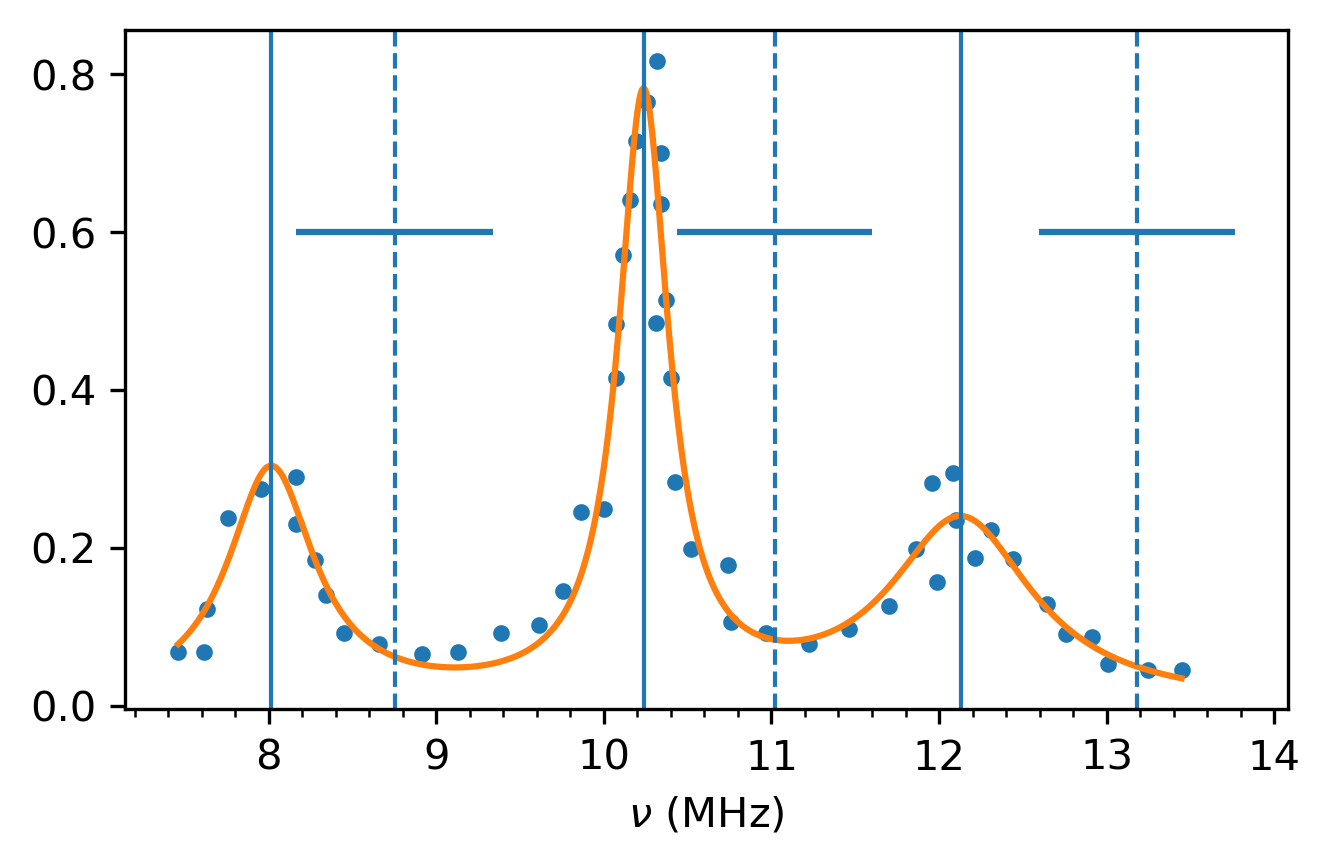

In [3]:
d = np.loadtxt('../data/raw/fukazawa_sparse.csv', delimiter=',')
x, y = d[:, 0], d[:, 1]

sort_i = np.argsort(x)
xs = x[sort_i]
ys = y[sort_i]

p1_guess = [0.3, 0.5, 8]
p2_guess = [0.8, 0.25, 10]
p3_guess = [0.3, 0.5, 12]
mymodel = Model(lorentz_sum)
mydata = RealData(xs, ys, sx=0.2, sy=5)
myodr = ODR(mydata, mymodel, beta0=[*p1_guess, *p2_guess, *p3_guess])
myoutput = myodr.run()

#myoutput.pprint()

fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.plot(xs, ys, '.')
x_plot = np.linspace(xs[0], xs[-1], 1000)
ax.plot(x_plot, lorentz_sum(myoutput.beta, x_plot))
ax.set_xlabel(r'$\nu$ (MHz)')
nu = [None]*3
for i in range(3):
    nom = (myoutput.beta[3*i + 2])
    nu[i] = ufloat(nom, 0.07)
nu = nu[::-1]
nuL = get_nuL(*nu)
nuQ = get_nuQ(*nu)
eta = get_eta(*nu)
for i in range(3):
    print(f'nu{i+1} = {nu[i]}')
print(nuL)
print(f'Bint = {nuL*1e6/GAMMA}')
print(f'nuQ = {nuQ}')
print(f'eta = {eta}')
print(f'eta nuQ = {eta*nuQ}')
print((eta*nuQ)**2/(3*nuL))
print(nuL)
get_nuL_approx(*nu)*1e6/GAMMA, get_nuQ_approx(*nu), get_eta_approx(*nu, nuL, nuQ)
#ax.plot(10.1*np.ones(50), np.linspace(0, 1))

# kit_nuc = 2.22057689/2*1e6
# kit_eta = 1.18487973
# kit_Bint = 1.49902115
kit_nuc = ufloat(2.22057689, 0.03)/2*1e6
kit_eta = ufloat(1.18487973, 0.05)
kit_Bint = ufloat(1.49902115, 0.08)
nuL = kit_Bint*GAMMA
beta = nuL/kit_nuc
nu_theor = [None]*4
# nu_theor[0] = kit_nuc*(beta - unp.sqrt((beta - 1)**2 + kit_eta**2/3) + unp.sqrt((beta + 1)**2 + kit_eta**2/3))/1e6
# nu_theor[1] = kit_nuc*(-beta + unp.sqrt((beta - 1)**2 + kit_eta**2/3) + unp.sqrt((beta + 1)**2 + kit_eta**2/3))/1e6
# nu_theor[2] = -kit_nuc*(-beta - unp.sqrt((beta - 1)**2 + kit_eta**2/3) + unp.sqrt((beta + 1)**2 + kit_eta**2/3))/1e6
# nu_theor[3] = kit_nuc*(beta + unp.sqrt((beta - 1)**2 + kit_eta**2/3) + unp.sqrt((beta + 1)**2 + kit_eta**2/3))/1e6
nu_theor[0] = (nuL - unp.sqrt((nuL - kit_nuc)**2 + (kit_nuc*kit_eta)**2/3) + unp.sqrt((nuL + kit_nuc)**2 + (kit_nuc*kit_eta)**2/3))/1e6
nu_theor[1] = (-nuL + unp.sqrt((nuL - kit_nuc)**2 + (kit_nuc*kit_eta)**2/3) + unp.sqrt((nuL + kit_nuc)**2 + (kit_nuc*kit_eta)**2/3))/1e6
nu_theor[2] = -(-nuL - unp.sqrt((nuL - kit_nuc)**2 + (kit_nuc*kit_eta)**2/3) + unp.sqrt((nuL + kit_nuc)**2 + (kit_nuc*kit_eta)**2/3))/1e6
nu_theor[3] = (nuL + unp.sqrt((nuL - kit_nuc)**2 + (kit_nuc*kit_eta)**2/3) + unp.sqrt((nuL + kit_nuc)**2 + (kit_nuc*kit_eta)**2/3))/1e6


for i in range(3):
    line = ax.axvline(nu_theor[i].n, ls='--', lw='1')
    ax.errorbar(nu_theor[i].n, 0.6, xerr=nu_theor[i].s, color=line.get_color())
    ax.axvline(nu[i].n, lw='1')
#ax.xaxis.grid(True, which='minor')

#ax.tick_params(which='minor', width=2)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
nu_theor[0] - nu_theor[1], nu_theor[1] - nu_theor[2], nu[0] - nu[1], nu[1] - nu[2]


NameError: name 'popt1' is not defined

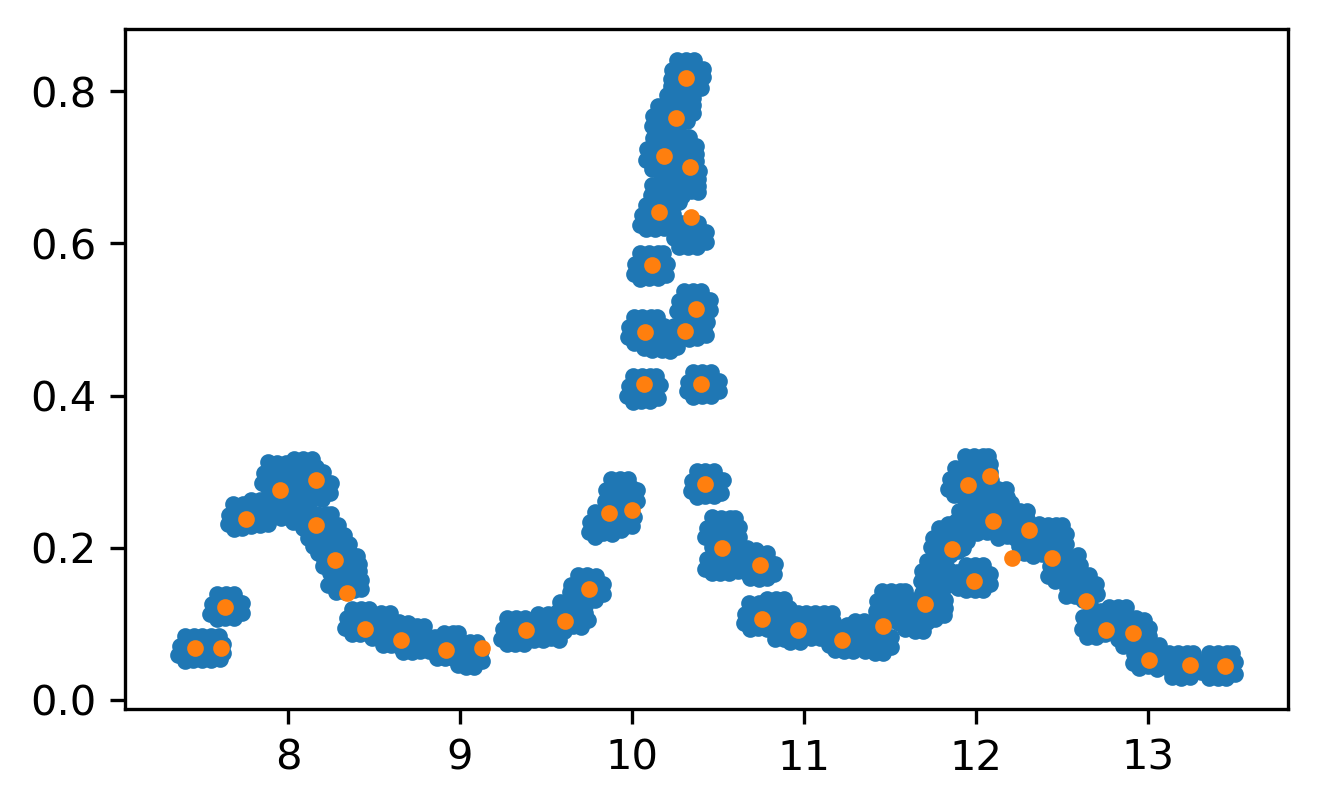

In [4]:
d1 = np.loadtxt('../data/raw/fukazawa_dense.csv', delimiter=',')
x1, y1 = d1[:, 0], d1[:, 1]
d2 = np.loadtxt('../data/raw/fukazawa_sparse.csv', delimiter=',')
x2, y2 = d2[:, 0], d2[:, 1]

# p1_guess = [0.3, 0.5, 8]
# p2_guess = [0.8, 0.25, 10]
# p3_guess = [0.3, 0.5, 12]
# popt1, pcov1 = curve_fit(lorentz_sumCF, x1, y1, p0=[*p1_guess, *p2_guess, *p3_guess])
# popt2, pcov2 = curve_fit(lorentz_sumCF, x2, y2, p0=[*p1_guess, *p2_guess, *p3_guess])
# popt1r = np.round(popt1, 1)
# popt2r = np.round(popt2, 1)
# perr1 = np.sqrt(np.diag(pcov1))
# perr2 = np.sqrt(np.diag(pcov2))

fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.plot(x1, y1, '.')
ax.plot(x2, y2, '.')
ax.plot(x1, lorentz_sumCF(x1, *popt1), label='dense')
ax.plot(x2, lorentz_sumCF(x2, *popt2), label='sparse')
ax.set_xlabel(r'$\nu$ (MHz)')
ax.legend(loc='best')
prec = 1
for i in range(3):
    print(np.round(popt1[3*i + 2], prec),
          '+/-',
          np.round(perr1[3*i + 2], prec))

## Baek

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.78.212509

57.340876939944295
61.51976177078014
65.6250717549837
nu1 = 48.00+/-0.10
nu2 = 45.00+/-0.10
nu3 = 41.94+/-0.10

nuQ = 1.515+/-0.035
eta = 1.3+/-2.9


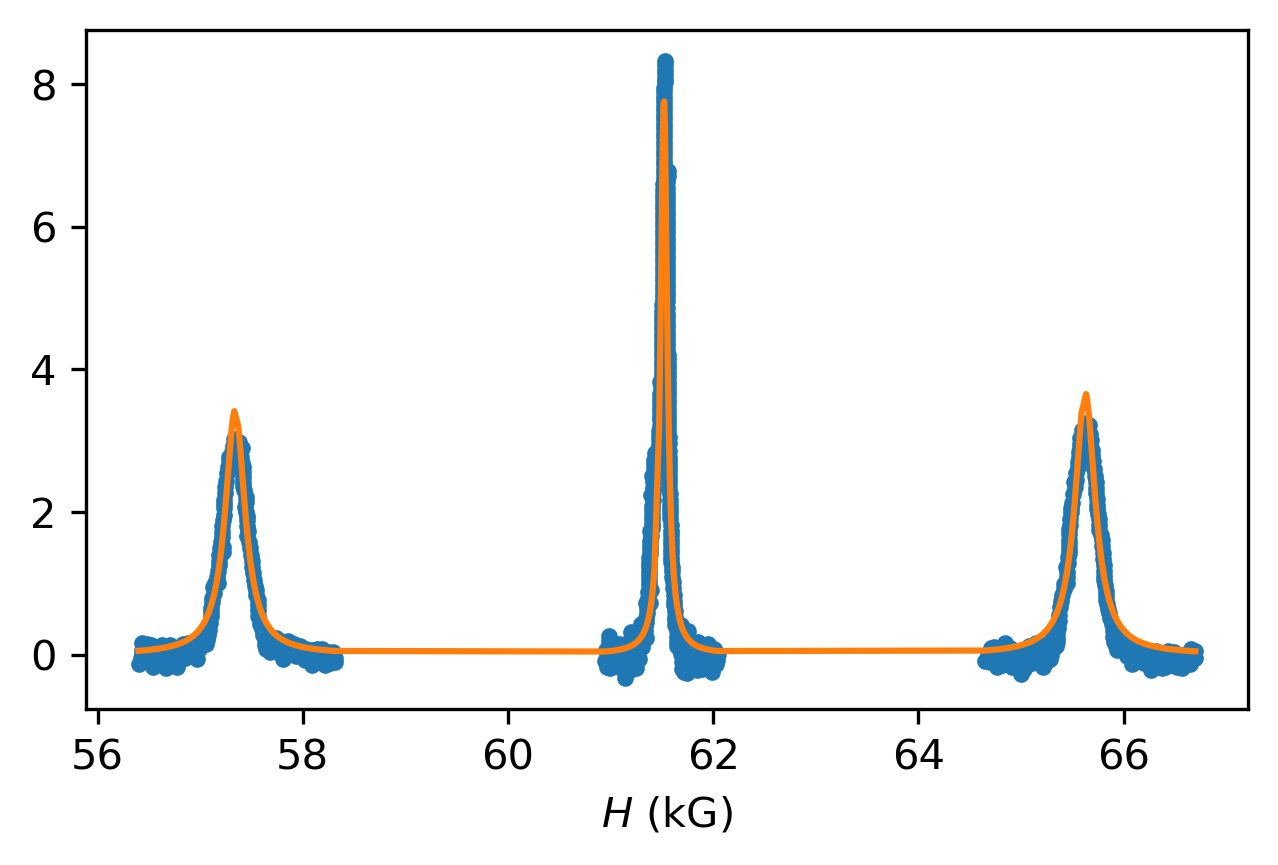

In [5]:
d = np.loadtxt('../data/raw/baek.csv', delimiter=',')
x, y = d[:, 0], d[:, 1]

sort_i = np.argsort(x)
xs = x[sort_i]
ys = y[sort_i]

p1_guess = [2.5, 1, 57.5]
p2_guess = [8, 0.25, 61.5]
p3_guess = [2.5, 1, 65.75]
mymodel = Model(lorentz_sum)
mydata = RealData(xs, ys, sx=0.1, sy=3)
myodr = ODR(mydata, mymodel, beta0=[*p1_guess, *p2_guess, *p3_guess])
myoutput = myodr.run()

#myoutput.pprint()

fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.plot(xs, ys, '.')
ax.plot(xs, lorentz_sum(myoutput.beta, xs))
ax.set_xlabel(r'$H$ (kG)')
nu = [None]*3
for i in range(3):
    val = myoutput.beta[3*i + 2]
    nom = (val*GAMMA/1e7)
    nu[i] = ufloat(nom, 0.1)
    print(val)
nu = nu[::-1]
nuL = get_nuL(*nu)
nuQ = get_nuQ(*nu)
eta = get_eta(*nu)
for i in range(3):
    print(f'nu{i+1} = {nu[i]}')
print()
#print(f'Bint = {nuL*1e6/GAMMA - 45*1e6/GAMMA}')
print(f'nuQ = {nuQ}')
print(f'eta = {eta}')

## Toyoda

https://journals.aps.org/prb/pdf/10.1103/PhysRevB.97.174507

nu1 = 58.23+/-0.20
nu2 = 57.20+/-0.20
nu3 = 56.23+/-0.20

nuL = 57.23+/-0.14
nuQ = 0.50+/-0.07


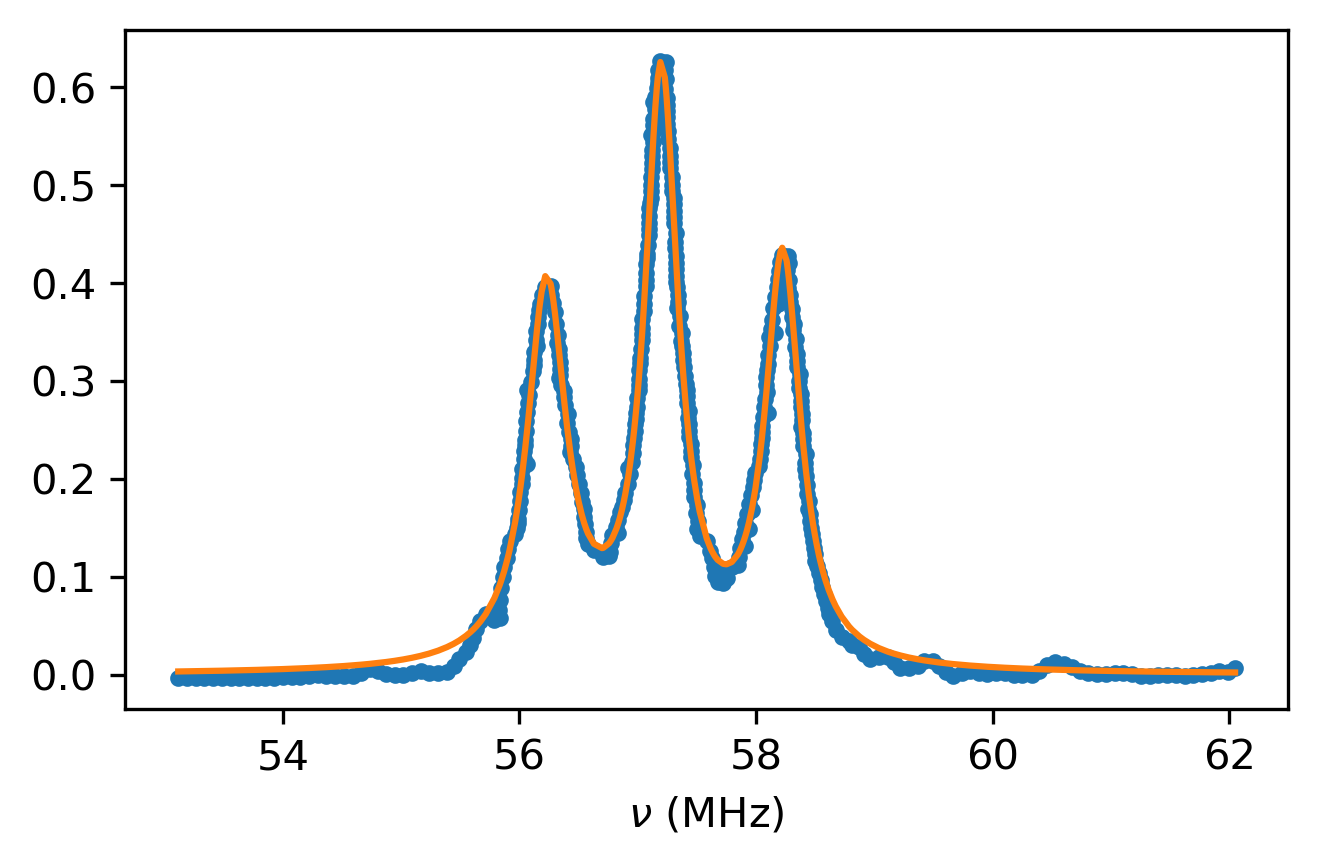

In [6]:
d = np.loadtxt('../data/raw/toyoda_50K.csv', delimiter=',')
x, y = d[:, 0], d[:, 1]

sort_i = np.argsort(x)
xs = x[sort_i]
ys = y[sort_i]

p1_guess = [0.4, 0.03, 56]
p2_guess = [0.6, 0.03, 57]
p3_guess = [0.4, 0.03, 58]
mymodel = Model(lorentz_sum)
mydata = RealData(xs, ys, sx=0.01, sy=1)
myodr = ODR(mydata, mymodel, beta0=[*p1_guess, *p2_guess, *p3_guess])
myoutput = myodr.run()

#myoutput.pprint()

fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.plot(xs, ys, '.')
ax.plot(xs, lorentz_sum(myoutput.beta, xs))
ax.set_xlabel(r'$\nu$ (MHz)')
nu = [None]*3
for i in range(3):
    nom = (myoutput.beta[3*i + 2])
    nu[i] = ufloat(nom, 0.2)
nu = nu[::-1]
nuL = get_nuL(*nu)
nuQ = get_nuQ(*nu)
for i in range(3):
    print(f'nu{i+1} = {nu[i]}')
print()
print(f'nuL = {nuL}')
print(f'nuQ = {nuQ}')
#print(f'eta = {eta}')
#get_Bint_EFG(nuL, nuQ, eta)

1.4647013116470362

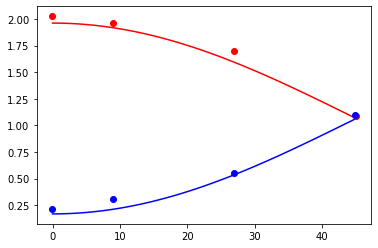

In [7]:
A = np.loadtxt('../data/raw/toyoda_A_fig2binset.csv', delimiter=',')
Ax, Ay = A[:, 0], A[:, 1]
B = np.loadtxt('../data/raw/toyoda_B_fig2binset.csv', delimiter=',')
Bx, By = B[:, 0], B[:, 1]

phi = np.linspace(0, np.pi/4)
H0 = 7.6999
Hin = 0.82
nuQ = 2.203
eta = 0.824
Heff = np.sqrt(H0**2 + Hin**2)
theta = np.arccos(Hin/Heff)
dnuA = np.abs(nuQ*(3*np.cos(theta)**2 - 1 + eta*np.sin(theta)**2*np.cos(2*(phi - np.pi/2)))/2)
dnuB = np.abs(nuQ*(3*np.cos(theta)**2 - 1 + eta*np.sin(theta)**2*np.cos(2*phi))/2)

plt.plot(phi*180/np.pi, dnuA, color='r')
plt.plot(phi*180/np.pi, dnuB, color='b')
plt.plot(Ax, Ay, 'o', color='r')
plt.plot(Bx, By, 'o', color='b')
theta

[2.36925759 0.75619376 1.40140782] [19081092.92371708  4178821.53137597  7389143.23524543]


(2.3692575945616525,
 0.7561937642127297,
 1.4014078170223419,
 1.3168937211372294)

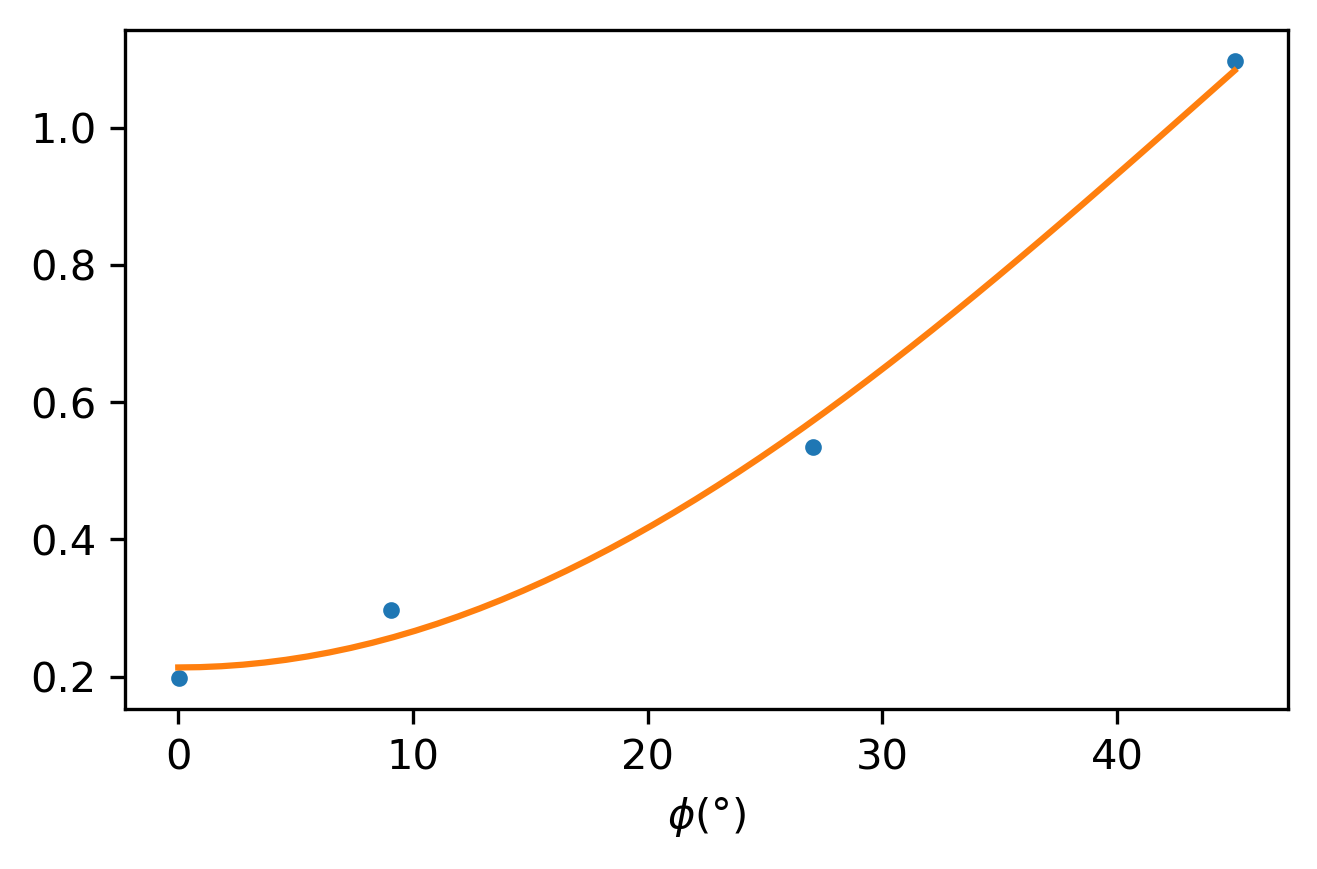

In [8]:
def func(x, *params):
    nuQ, eta, theta = params
    return np.abs(nuQ*(3*np.cos(theta)**2 - 1 + eta*np.sin(theta)**2*np.cos(2*x))/2)
    #return np.abs(nuQ*(3*(1 - s**2) - 1 + eta*s**2*np.cos(2*x))/2)

B = get_wpd('../data/raw/toyoda_135.tar', 'B')
Bx, By = B[:, 0]*np.pi/180, B[:, 1]
H0 = 7.6999

phi = np.linspace(0, np.pi/4)
guess = [2, 0.5, 1.46]
popt, pcov = curve_fit(func, Bx, By, p0=guess, sigma=0.1*np.ones(Bx.size))
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.plot(Bx*180/np.pi, By, '.')
ax.plot(phi*180/np.pi, func(phi, *popt))#1.137, -55.6, 2.976))
ax.set_xlabel(r'$\phi (\degree)$')
popt[0], popt[1], popt[2], H0/np.tan(popt[2])

[2.27384393 0.76459753 1.4543385 ] [11757132.46257197  2671688.57587992  7164700.51491133]


Text(0.5, 0, '$\\phi (\\degree)$')

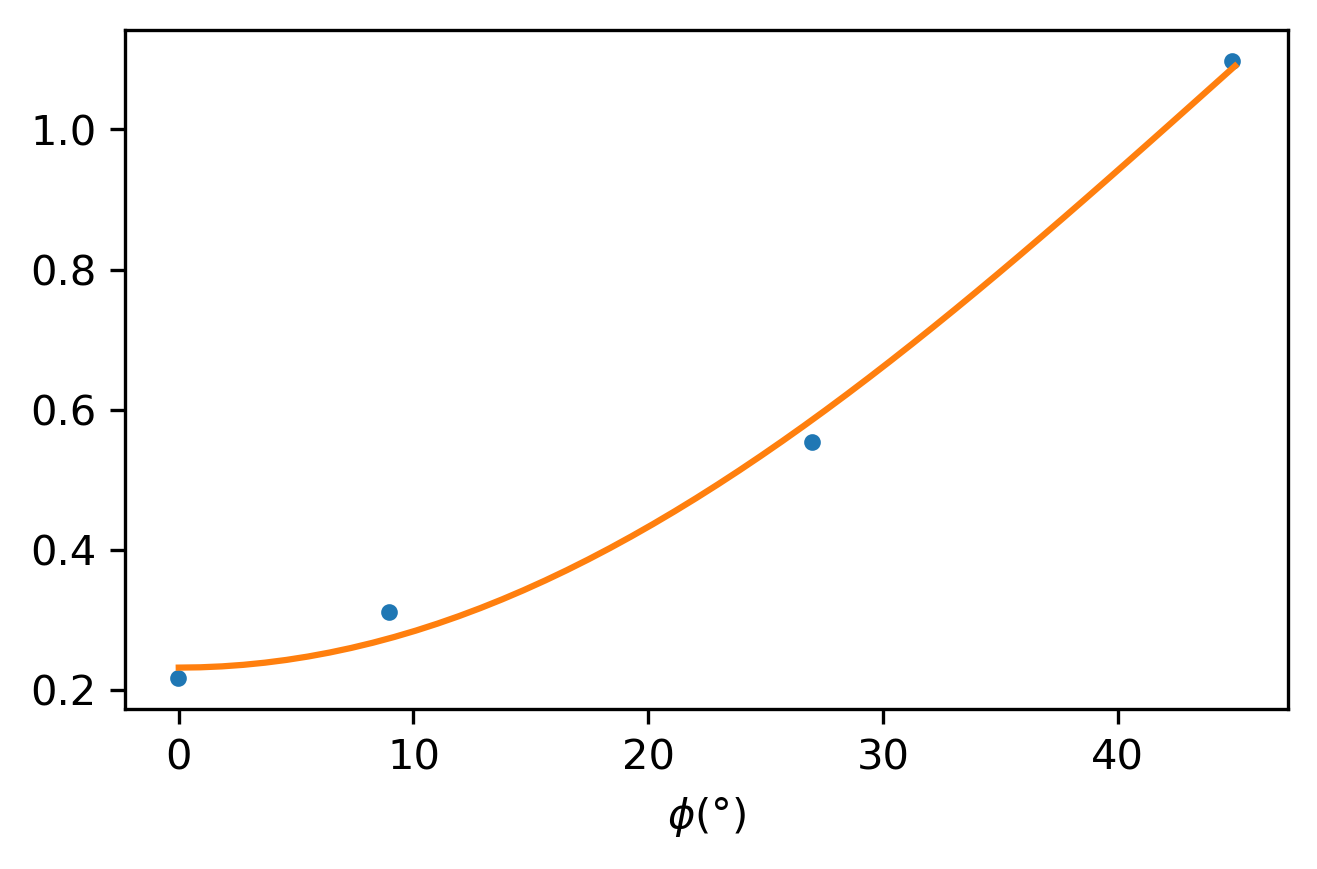

In [9]:
def func(x, *params):
    nuQ, eta, theta = params
    return np.abs(nuQ*(3*np.cos(theta)**2 - 1 + eta*np.sin(theta)**2*np.cos(2*x))/2)
    #return np.abs(nuQ*(3*(1 - s**2) - 1 + eta*s**2*np.cos(2*x))/2)

B = np.loadtxt('../data/raw/toyoda_B_fig2binset.csv', delimiter=',')
Bx, By = B[:, 0]*np.pi/180, B[:, 1]

phi = np.linspace(0, np.pi/4)
guess = [2, 0.5, 1.46]
popt, pcov = curve_fit(func, Bx, By, p0=guess, sigma=0.2*np.ones(Bx.size))
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.plot(Bx*180/np.pi, By, '.')
ax.plot(phi*180/np.pi, func(phi, 1.137, -55.6, 2.976))
ax.set_xlabel(r'$\phi (\degree)$')
# prec = 1
# for i in range(3):
#     print(np.round(popt1[3*i + 2], prec),
#           '+/-',
#           np.round(perr1[3*i + 2], prec))

Beta: [2.20068293 0.77979733 1.51494896]
Beta Std Error: [180257.7266006   42715.18332422 242665.25372301]
Beta Covariance: [[ 5.48710404e+11 -1.30026412e+11 -7.38680953e+11]
 [-1.30026412e+11  3.08120054e+10  1.75043217e+11]
 [-7.38680953e+11  1.75043217e+11  9.94421733e+11]]
Residual Variance: 0.05921675220263023
Inverse Condition #: 6.546838036941159e-08
Reason(s) for Halting:
  Sum of squares convergence
nuQ =  2.200682925455888
eta =  0.779797332753554


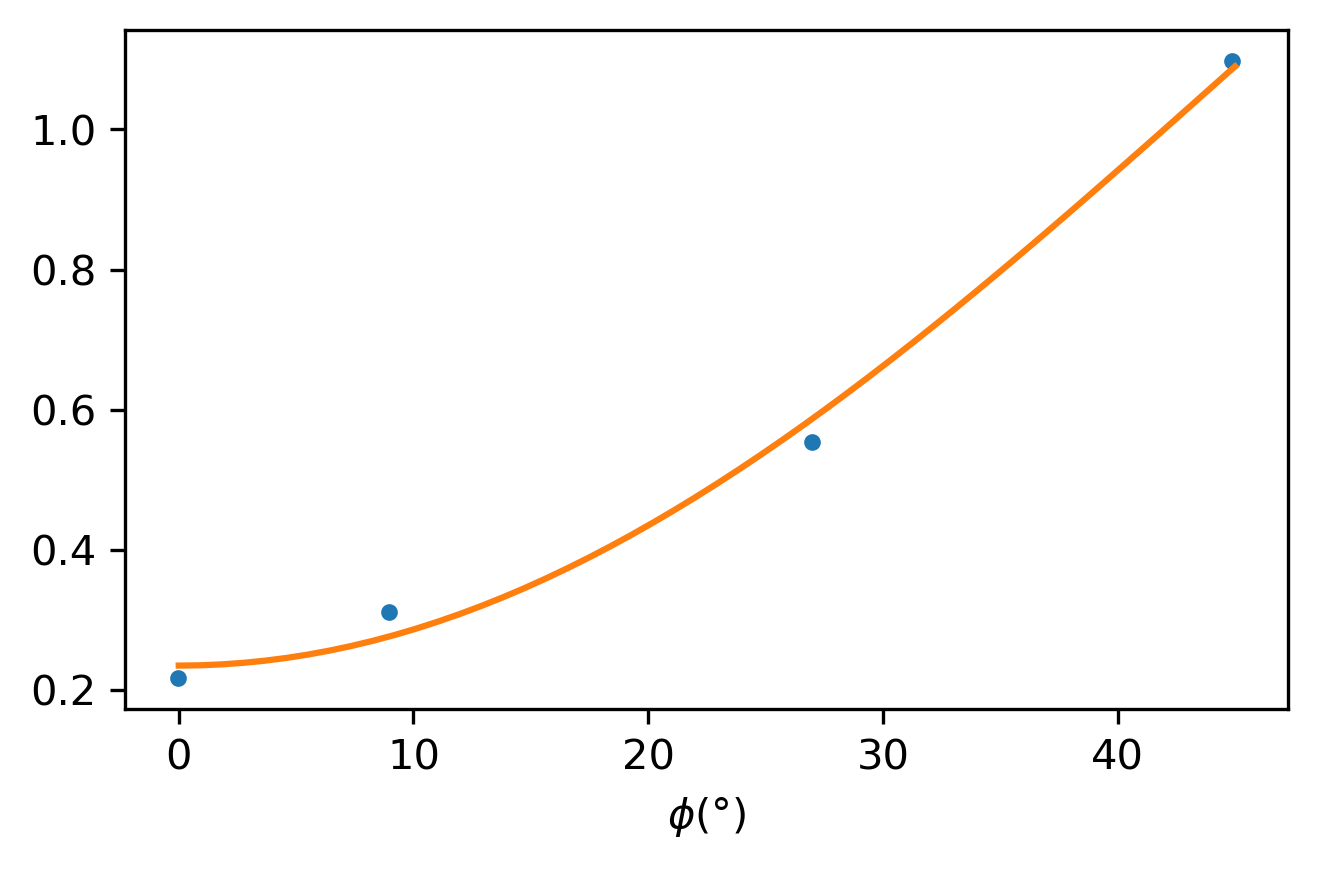

In [10]:
def func(params, x):
    nuQ, eta, theta = params
    #nuQ, eta, s = params
    return np.abs(nuQ*(3*np.cos(theta)**2 - 1 + eta*np.sin(theta)**2*np.cos(2*x))/2)
    #return np.abs(nuQ*(3*(1 - s) - 1 + eta*s*np.cos(2*x))/2)

B = np.loadtxt('../data/raw/toyoda_B_fig2binset.csv', delimiter=',')
Bx, By = B[:, 0]*np.pi/180, B[:, 1]

phi = np.linspace(0, np.pi/4)
guess = [2.203, 0.824, 1.465]
mymodel = Model(func)
# sx=(11.2-6.5)/2*np.pi/180*np.ones(Bx.size)
# sy=(0.4-0.8)/2*np.ones(Bx.size)
sx=5*np.pi/180*np.ones(Bx.size)
sy=0.2*np.ones(Bx.size)
mydata = RealData(Bx, By, sy=sy, sx=sx)#wd=1./np.power(sx,2), we=1./np.power(sy,2))
myodr = ODR(mydata, mymodel, beta0=guess)
myoutput = myodr.run()

myoutput.pprint()

fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.plot(Bx*180/np.pi, By, '.')
ax.plot(phi*180/np.pi, func(myoutput.beta, phi))
ax.set_xlabel(r'$\phi (\degree)$')
print('nuQ = ', myoutput.beta[0])
print('eta = ', myoutput.beta[1])
# nu = [None]*3
# for i in range(3):
#     nom = (myoutput.beta[3*i + 2])
#     nu[i] = ufloat(nom, 0.1)
# nu = nu[::-1]
# nuL = get_nuL(*nu)
# nuQ = get_nuQ(*nu)
# for i in range(3):
#     print(f'nu{i+1} = {nu[i]}')
# print()
# print(f'nuL = {nuL}')
# print(f'nuQ = {nuQ}')
# #print(f'eta = {eta}')
# #get_Bint_EFG(nuL, nuQ, eta)

## Kitagawa

https://sci-hub.se/10.1143/jpsj.77.114709

(array([10.13333333,  2.22057689]),
 array([10.        ,  1.18487973]),
 array([10.        ,  1.49902115]))

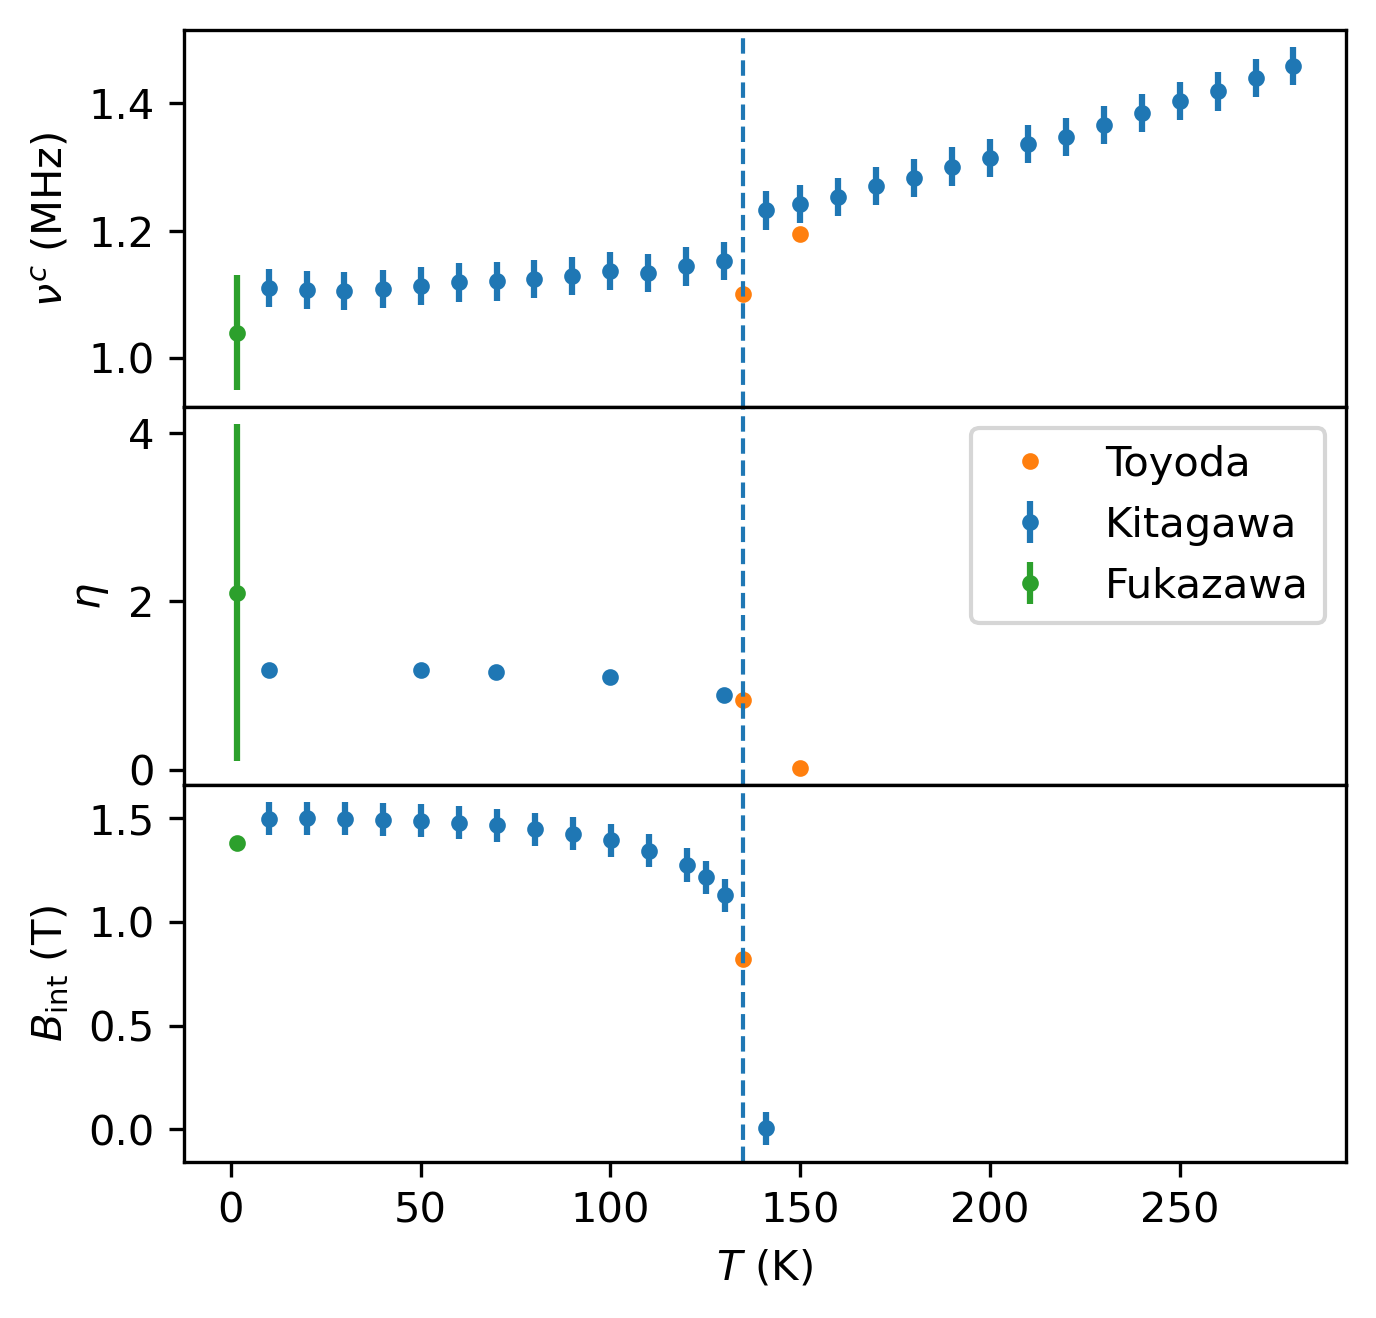

In [11]:
fig, [ax1, ax2, ax3] = plt.subplots(3, sharex=True, figsize=(5, 5), dpi=300, gridspec_kw={'hspace': 0})     

# Kitagawa
nuc = get_wpd('../data/raw/kitagawa2008_nuc_eta.tar', 'nuc')
eta = get_wpd('../data/raw/kitagawa2008_nuc_eta.tar', 'eta')
Bint = get_wpd('../data/raw/kitagawa2008_Bint.tar', 'Default Dataset')
ax1.errorbar(nuc[:, 0], nuc[:, 1]/2, marker='.', ls='none', yerr=0.03)#, xerr=6)
ax2.errorbar(eta[:, 0], eta[:, 1],   marker='.', ls='none', label='Kitagawa', yerr=0.05)#, xerr=6)
ax3.errorbar(Bint[:, 0], Bint[:, 1], marker='.', ls='none', yerr=0.08)#, xerr=6)
ax3.set_xlabel(r'$ T $ (K)')
ax1.set_ylabel(r'$\nu^c$ (MHz)')
ax2.set_ylabel(r'$\eta$')
ax3.set_ylabel(r'$B_\mathrm{int}$ (T)')

# Toyoda
toyoda = {135: {'Bint': 0.82, 'nuc': 2.203, 'eta': 0.824},
          #135: {'nuc': 2.36925759, 'eta': 0.75619376, 'Bint': 1.3168937211372294},
          150: {'nuc': 2.39, 'eta': 0.025}}
T = 135
line = ax1.plot(T, toyoda[T]['nuc']/2, '.')
ax2.plot(T, toyoda[T]['eta'], '.', label='Toyoda')
ax3.plot(T, toyoda[T]['Bint'], '.')
T = 150
ax1.plot(T, toyoda[T]['nuc']/2, '.', color=line[-1].get_color())
ax2.plot(T, toyoda[T]['eta'], '.', color=line[-1].get_color())

ax1.axvline(135, ls='--', lw='1')
ax2.axvline(135, ls='--', lw='1')
ax3.axvline(135, ls='--', lw='1')


# Fukazawa
fukazawa = {1.5: {'Bint': 1.38, 'nuc': 1.04, 'eta': 2.1}}
T = 1.5
line = ax1.errorbar(T, fukazawa[T]['nuc'], marker='.', ls='none', yerr=0.09)
ax2.errorbar(T, fukazawa[T]['eta'], marker='.', color=line.lines[0].get_color(), ls='none', label='Fukazawa', yerr=2)
ax3.errorbar(T, fukazawa[T]['Bint'], marker='.', color=line.lines[0].get_color(), ls='none', label='Fukazawa', yerr=0.02)

custom_lines = [mpl.lines.Line2D([0], [0], marker='.', ls='none'),
                mpl.lines.Line2D([0], [0], marker='*', ls='none')]
labels = ['Kitagawa', 'Toyoda']
ax2.legend()#custom_lines, labels)#, loc='best')
nuc[0], eta[0], Bint[0], 

In [13]:
nuc, eta

(array([[ 10.13333333,   2.22057689],
        [ 20.        ,   2.21301394],
        [ 29.86666667,   2.2106086 ],
        [ 40.        ,   2.21794231],
        [ 50.        ,   2.22699675],
        [ 60.        ,   2.23777039],
        [ 70.13333333,   2.24109265],
        [ 80.        ,   2.24842942],
        [ 90.        ,   2.25748386],
        [100.        ,   2.27398816],
        [110.        ,   2.26642369],
        [120.        ,   2.28808558],
        [130.        ,   2.30630907],
        [141.06666667,   2.46377536],
        [150.        ,   2.48430334],
        [160.        ,   2.50711137],
        [170.13333333,   2.54137918],
        [180.        ,   2.56705406],
        [190.        ,   2.60189647],
        [200.        ,   2.62871595],
        [210.        ,   2.67272741],
        [220.        ,   2.6943893 ],
        [230.        ,   2.73209704],
        [240.        ,   2.77095091],
        [250.        ,   2.80693945],
        [260.13333333,   2.83776886],
        [270

# Mixing

In [ ]:
def get_efg(Vcc, eta):
    Vaa = Vcc*(eta - 1)/2
    Vbb = -Vcc*(eta + 1)/2
    
    #print((Vbb - Vaa)/Vcc)
    return np.diag([Vbb, Vcc, Vaa])

def mix(mag, nonmag, _exp, prec=3):
    ids = np.argsort(np.abs(np.diag(_exp)))
    exp = np.diag(_exp)#[ids]
    best_avg = 100
    best_k = 0
    for k in np.linspace(0, 1, 10**prec):
        _mix = np.diag(k*mag + (1 - k)*nonmag)
        ids = np.argsort(np.abs(_mix))
        mix = _mix#[ids]
        #print(mix, exp)
        avg = np.average(np.abs((np.abs(exp) - np.abs(mix)))/np.abs(exp))
        #print(avg)
        if avg < best_avg:
            best_avg = avg
            best_k = k
            #print(avg)
    
    return best_k

# MAG
mag = 1e21*np.array([[1.35073,   -0.00057, 0.00000],
                     [-0.00057, 0.35056, 0.00000],
                     [0.00000, 0.00000, -1.70128]])
    
# Nonmag
nonmag = 1e21*np.array([[0.55821, 0.00046, 0.00000],      
                        [0.00046, -0.91012, 0.00000],
                        [0.00000, 0.00000, 0.35192]])

nuc_afm = get_wpd('../data/raw/kitagawa2008_nuc_eta.tar', 'nuc')[0, 1]
eta_afm = get_wpd('../data/raw/kitagawa2008_nuc_eta.tar', 'eta')[0, 1]
Vcc_afm = nuc_afm*1e6*2*PLANK_CONST/(ECHARGE*QUADMOM)
efg_afm = get_efg(Vcc_afm, eta_afm)

# 135
nuc_nem = 2.203
eta_nem = 0.824

# 150
# nuc_nem = 2.39
# eta_nem = 0.025
Vcc_nem = nuc_nem*1e6*2*PLANK_CONST/(ECHARGE*QUADMOM)
efg_nem = get_efg(Vcc_nem, eta_nem)

k_afm = mix(mag, nonmag, efg_afm)
k_nem = mix(mag, nonmag, efg_nem)
#k1 = np.average(np.abs(np.matmul((efg_afm - nonmag), np.linalg.inv(mag - nonmag))))

#efg_afm/1e21, (k_afm*mag + (1 - k_afm)*nonmag)/1e21, efg_nem/1e21, (k_nem*mag + (1 - k_nem)*nonmag)/1e21, k_afm, k_nem, mix2(mag, nonmag, efg_afm)
mix2(mag, nonmag, efg_afm)

In [ ]:
#LaFeAsO
def get_efg(Vcc, eta):
    Vaa = Vcc*(eta - 1)/2
    Vbb = -Vcc*(eta + 1)/2
    
    return np.diag([Vcc, Vbb, Vaa])

def mix(mag, nonmag, _exp, prec=3):
    ids = np.argsort(np.abs(np.diag(_exp)))
    exp = np.diag(_exp)[ids]
    best_avg = 100
    best_k = 0
    for k in np.linspace(0, 1, 10**prec):
        _mix = np.diag(k*mag + (1 - k)*nonmag)
        ids = np.argsort(np.abs(_mix))
        mix = _mix[ids]
        #print(mix, exp)
        avg = np.average(np.abs((np.abs(exp) - np.abs(mix)))/np.abs(exp))
        #print(avg)
        if avg < best_avg:
            best_avg = avg
            best_k = k
    
    return best_k

def mix2(_mag, _nonmag, _exp):
    mag = np.abs(_mag)
    nonmag = np.abs(_nonmag)
    exp = np.abs(_exp)
    
    A = np.array([[mag[0, 0] + nonmag[0, 0]], [mag[1, 1] + nonmag[1, 1]]])#.reshape(2, 1)
    b = np.array([exp[0, 0] + nonmag[0, 0], exp[1, 1] + nonmag[1, 1]])
#     print(mag)
#     print(nonmag)
#     print(A, b)
    print(_exp)
    ls = np.linalg.lstsq(A, b, rcond=None)
    k = ls[0]
    print(ls)
    print(k*_mag + (k - 1)*_nonmag)
    #return k1, k2

mag = np.array([[-0.87427, -0.00000, 0.00000],
                [-0.00000, 1.66196, 0.00000],
                [0.00000, 0.00000, -0.78769]])
nonmag = np.array([[-2.80217, -0.00152, 0.00000],
                   [-0.00152, 1.40351, 0.00000],
                   [0.00000, 0.00000, 1.39866]])

efg_afm = get_efg(2.33, 0.32)

k = mix(mag, nonmag, efg_afm)
k1 = np.average(np.abs(np.matmul((efg_afm - nonmag), np.linalg.inv(mag - nonmag))))

efg_afm, (k*mag + (1 - k)*nonmag), k#, (k1*mag + (1 - k1)*nonmag)/1e21, k, k1
mix2(mag, nonmag, efg_afm)

In [ ]:
# MAG
 1.35073   -0.00057    0.00000        
-0.00057    0.35056    0.00000
 0.00000    0.00000   -1.70128
    
# Nonmag
0.55821    0.00046    0.00000      
0.00046   -0.91012    0.00000 
0.00000    0.00000    0.35192

In [ ]:
#units = np.array([r'$10^{21} \mathrm{V m}^{-2}$']*3 + [1, 'K'])
source = np.array(['Toyoda18', 'Toyoda18', 'Fukazawa08', 'Baek08'])
stype = np.array(['SC', 'SC', 'PC', 'SC'])
temp = np.array([135, 150, 1.5, 120], dtype='str')
Bint = np.array([0.82, '?', 1.38, '?'], dtype='str')
nuQ = np.array([2.203, 2.39, '1.04+/-0.04', 3.0], dtype='str')
eta = np.array([0.824, 0.025, '2.1+/-0.8', '?'], dtype='str')
d = {'source': source, r'$T$ (K)': temp, r'$B_\text{int}$ (T)': Bint, r'$\nu_Q$ (MHz)': nuQ, r'$\eta$': eta}
df = pd.DataFrame(d).sort_values(r'$T$ (K)')#, index=source)
#df.columns.name = r'$10^{21} \mathrm{V m}^{-2}$'
df_styler = df.style.set_table_attributes('style="font-size: 30px"')
df_styler

In [ ]:
I = 3/2
for m in [3/2, 1/2, -1/2, -3/2]:
    i = I*(I + 1) - m*(m - 1)
    print(i)